<a href="https://colab.research.google.com/github/TheAmirHK/Experiments/blob/main/ExplainableAITools/AI_Explain(test).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The dataset in this code was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a population
of 600 to 3,000 people).
Refer to: https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import shap
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from captum.attr import IntegratedGradients

In [ ]:
data =  fetch_california_housing()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [73]:
print(data.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


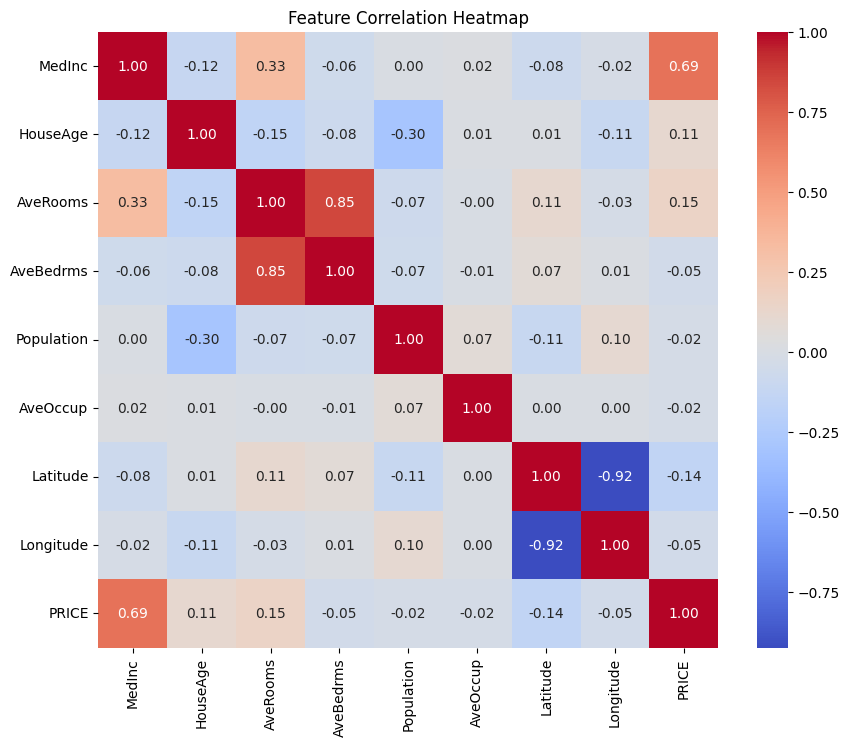

In [53]:
import seaborn as sns
import pandas as pd

feature_names = data.feature_names

df = pd.DataFrame(X, columns=feature_names)
df['PRICE'] = y
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
import keras

model = Sequential([
    Dense(512, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='tanh'),
    Dense(1)
])

opt = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss='huber', optimizer=opt)

model.fit(X_train, y_train, epochs=200, batch_size=500, verbose=1, validation_data=(X_test, y_test))

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.6349 - val_loss: 0.2495
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1878 - val_loss: 0.2419
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1680 - val_loss: 0.1694
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1441 - val_loss: 0.2660
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1581 - val_loss: 0.1412
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1295 - val_loss: 0.1692
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1370 - val_loss: 0.1547
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1286 - val_loss: 0.2716
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1422 - val_loss: 0.2200
Epoch 10/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.1392 - val_loss: 0.1856
Epoch 11/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1363 - val_loss: 0.1439
Epoch 12/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

In [97]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train MAE: {train_mae:.2f}, R2: {train_r2:.2f}")
print(f"Test MAE: {test_mae:.2f}, R2: {test_r2:.2f}")

516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train MAE: 0.19, R2: 0.94
Test MAE: 0.36, R2: 0.76


ExactExplainer explainer: 4129it [22:03,  3.10it/s]


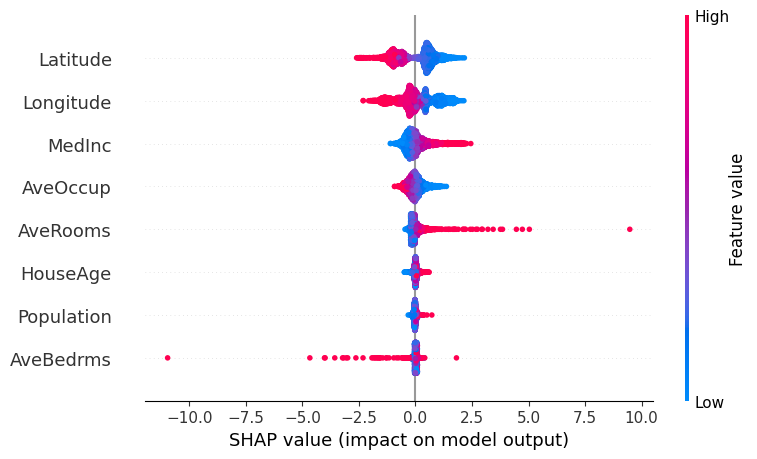

In [65]:
# Explain with SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

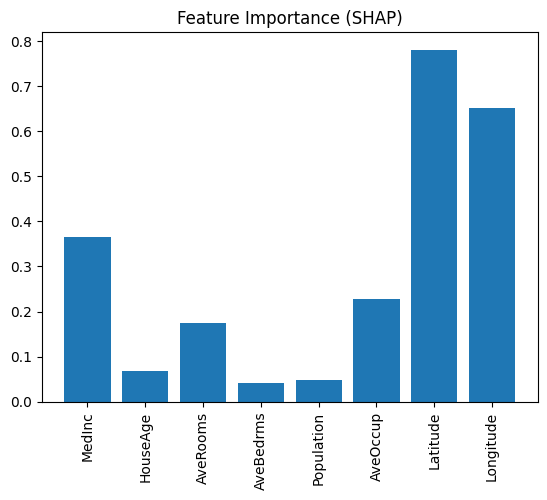

In [88]:
importances = np.abs(shap_values.values).mean(axis=0)
plt.bar(data.feature_names, importances)
plt.xticks(rotation=90)
plt.title("Feature Importance (SHAP)")
plt.show()

In [98]:
# Explain with Lime

def predict_proba(X):
    return model.predict(X)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=data.feature_names, class_names=['price'], mode='regression')
explanation = explainer.explain_instance(X_test[0], predict_proba)
explanation.show_in_notebook()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
